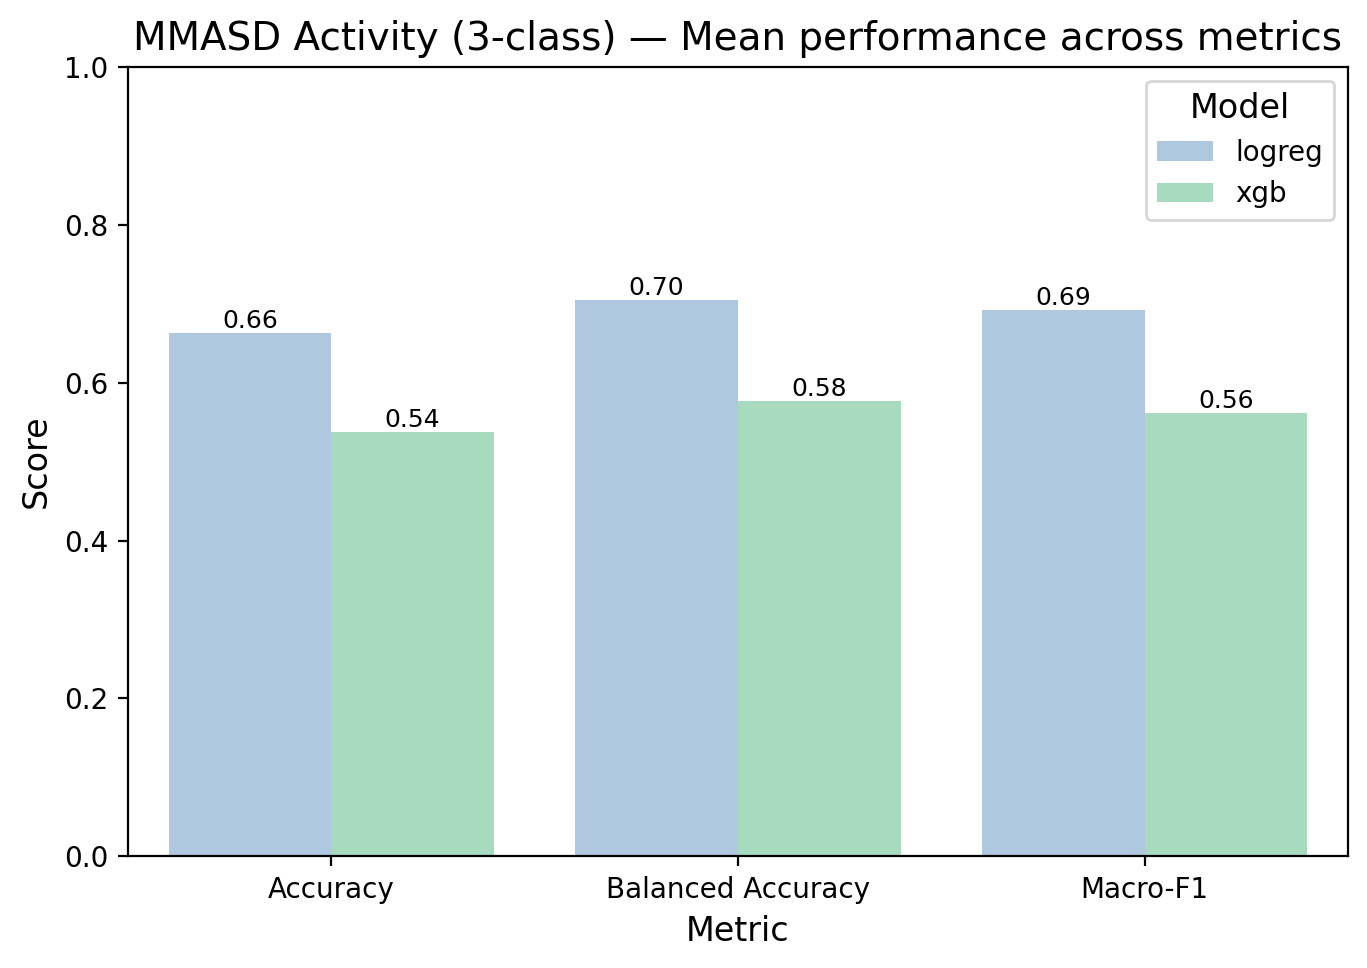

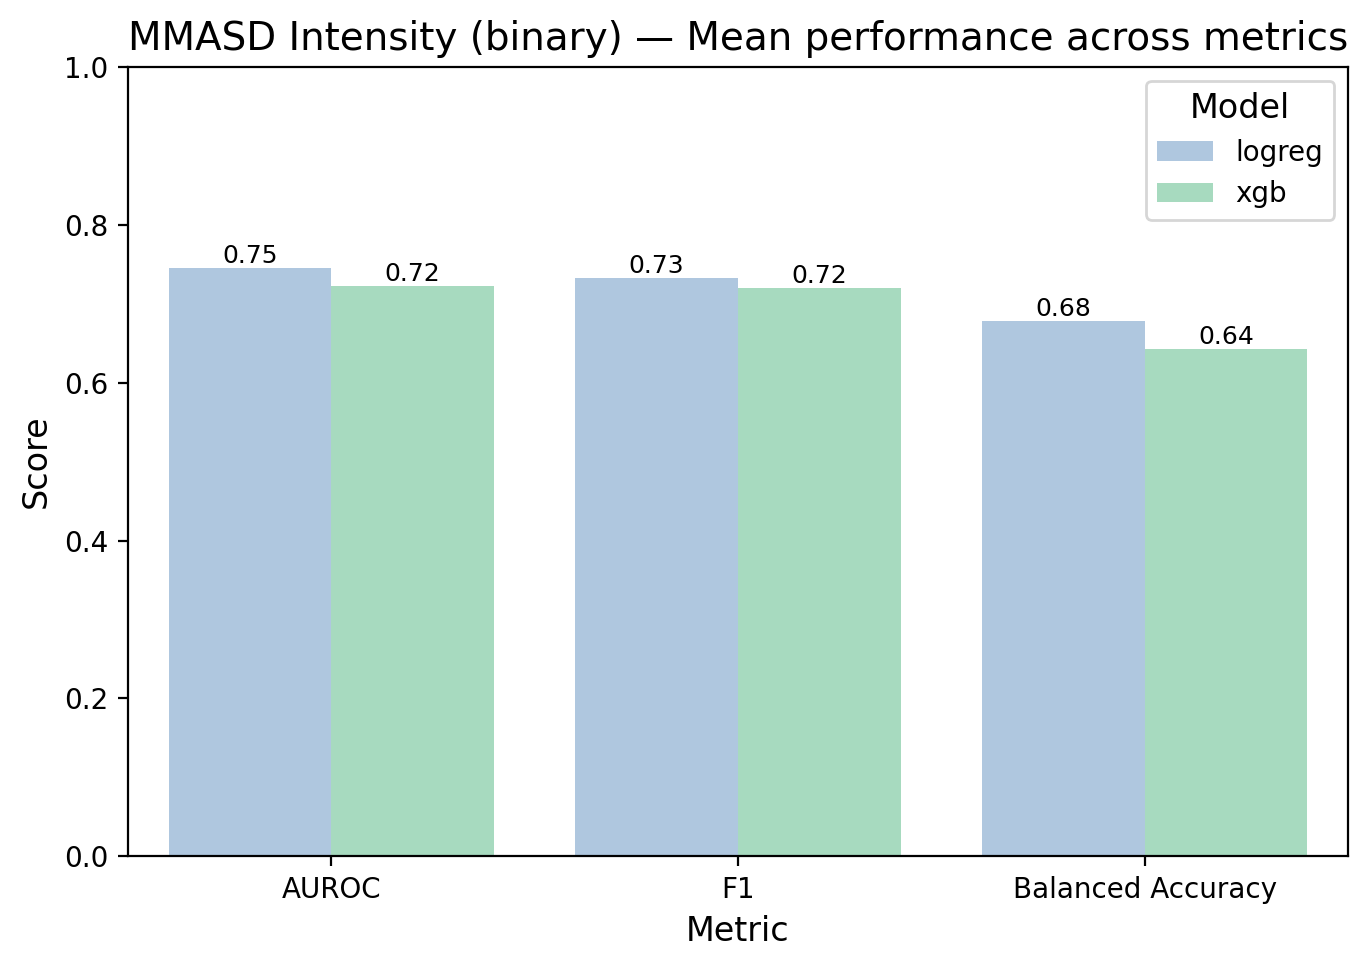

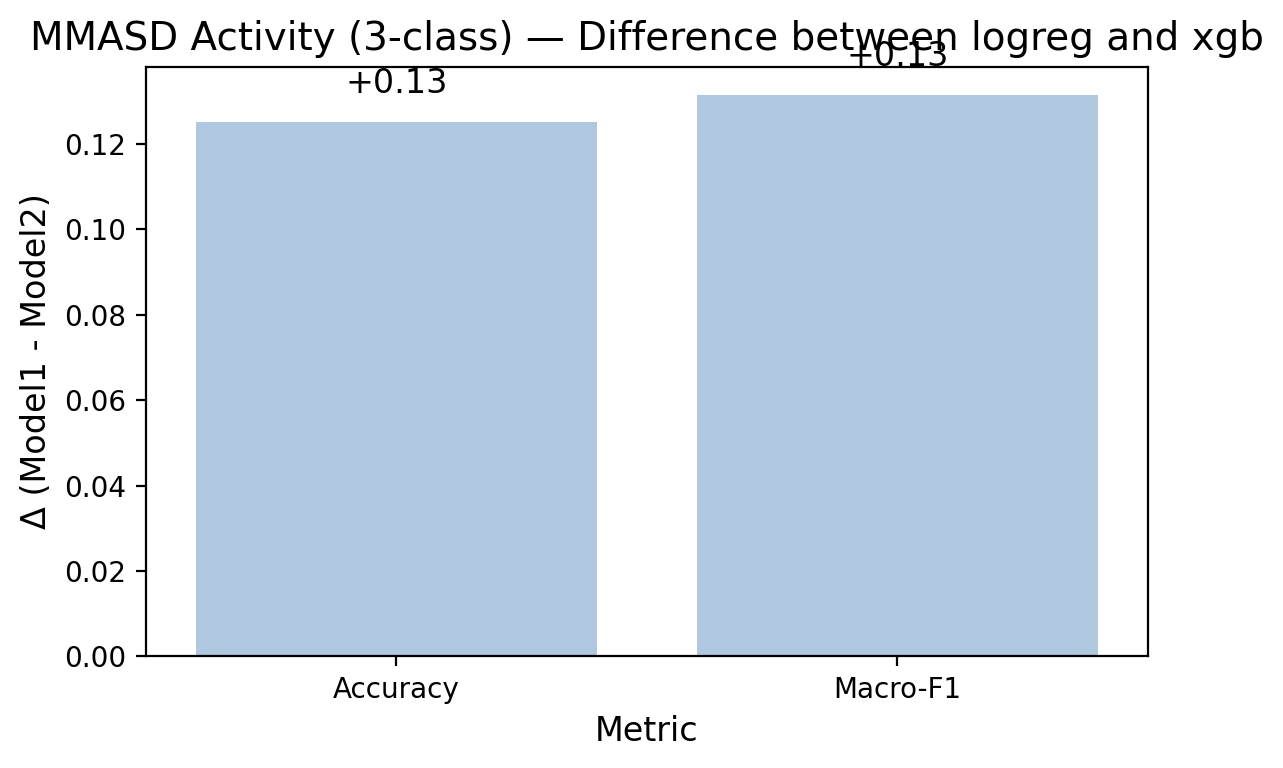

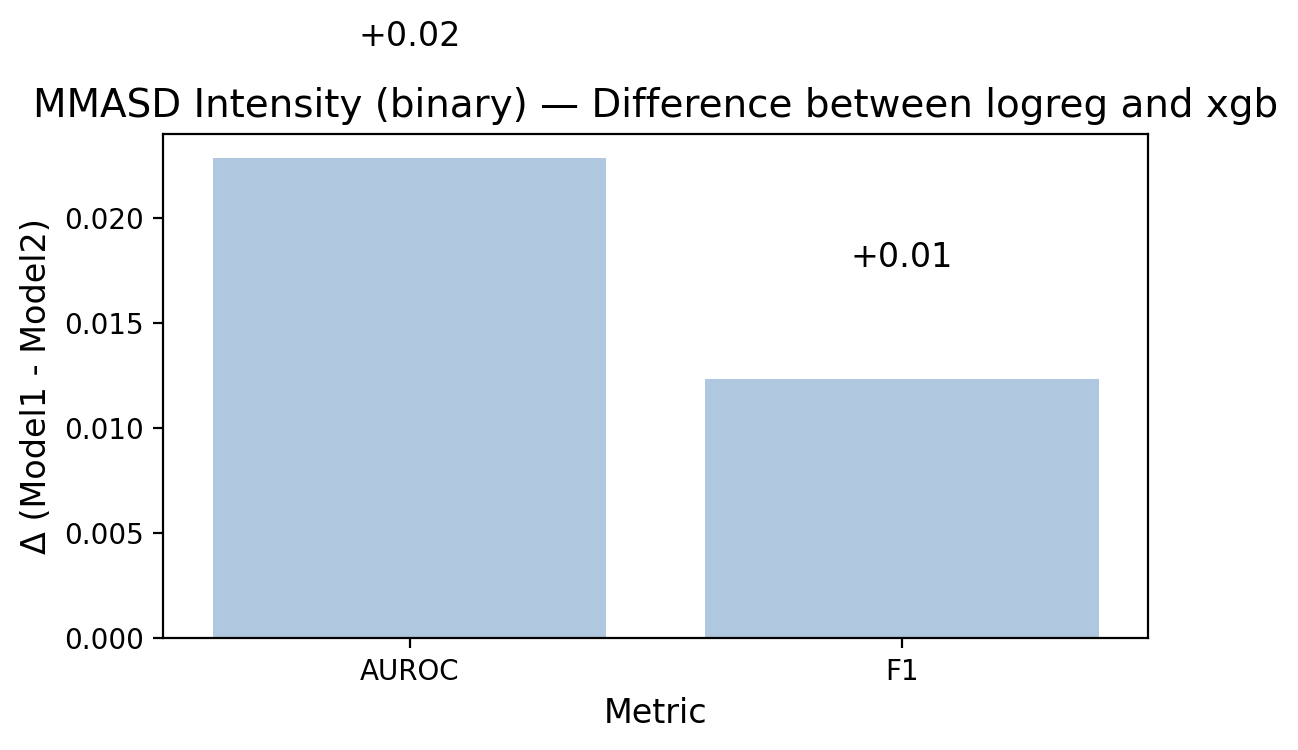

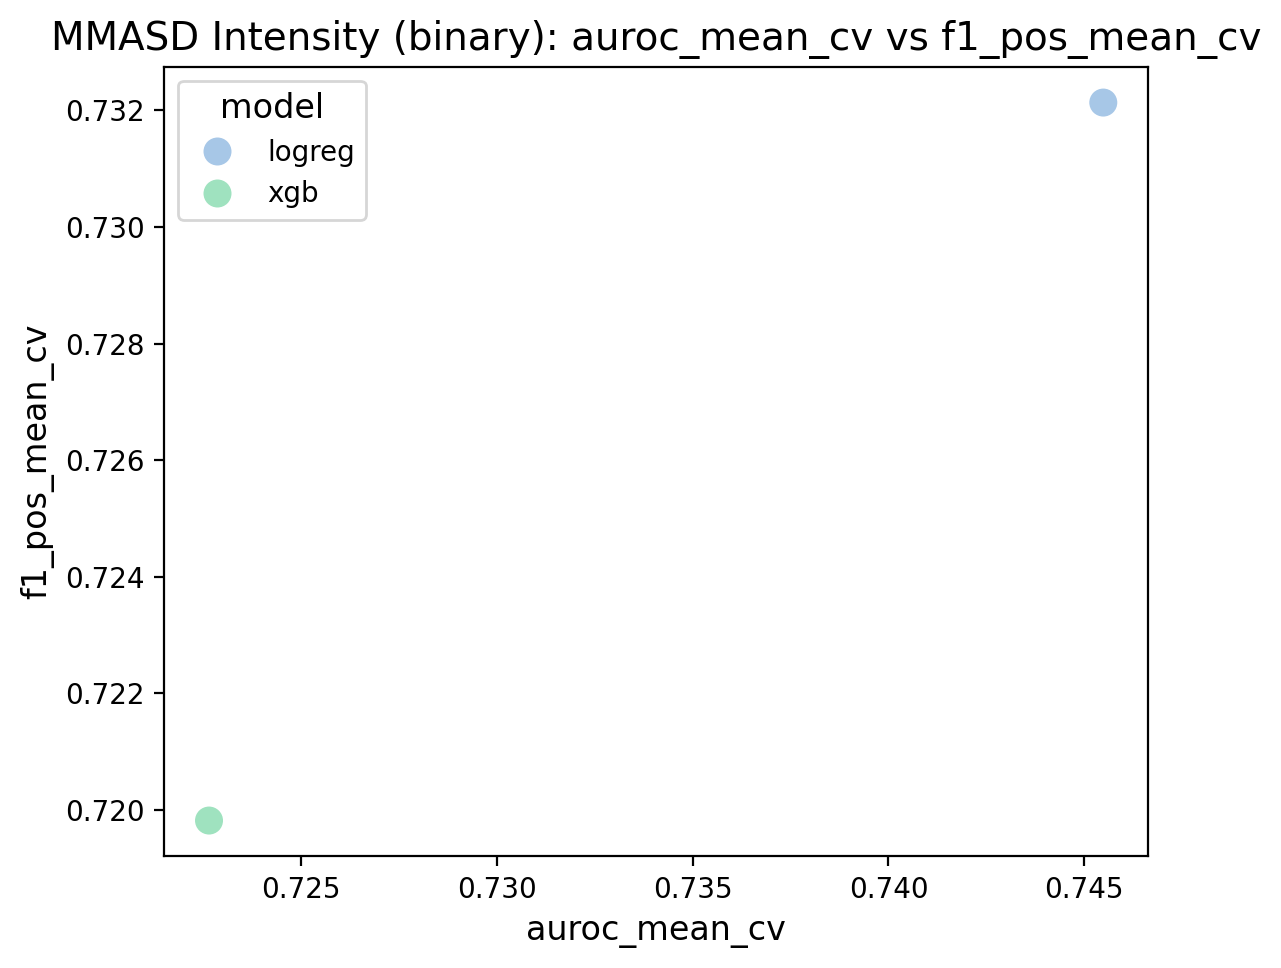

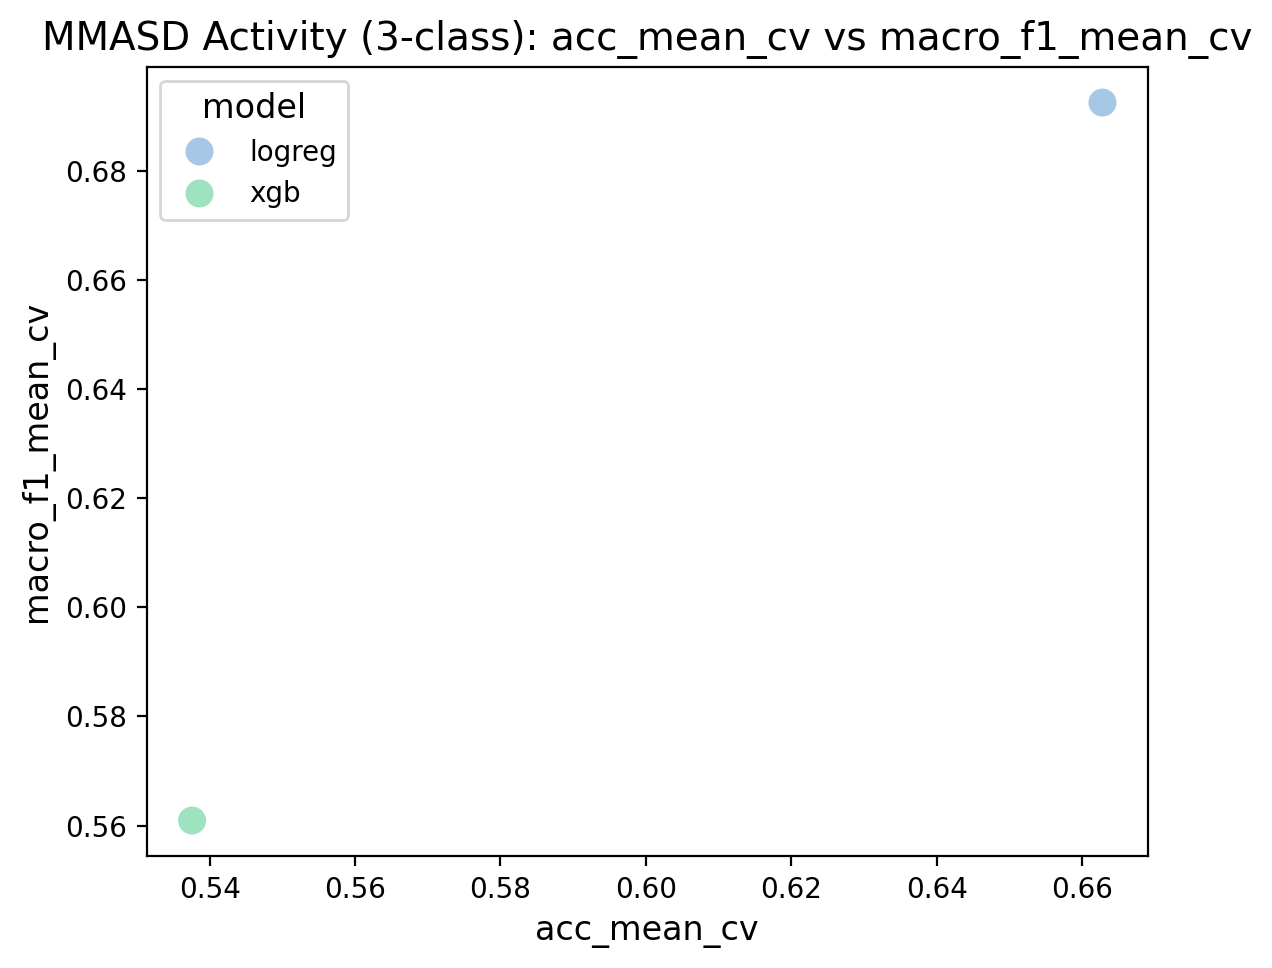

✅ Figures saved in: C:\Users\rusla\Desktop\Ruslan\AutDB-Video\data\Baseline\Experement - 2 (MMASD)\outputs\figs_pub_ready


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

#CONFIG
plt.rcParams.update({
    "figure.dpi": 200, "font.size": 12,
    "axes.titlesize": 14, "axes.labelsize": 12
})
OUTDIR = Path("figs_pub_ready"); OUTDIR.mkdir(exist_ok=True)

# Цветовая схема
COLOR_PALETTE = ["#A7C7E7", "#9FE2BF"]

# Load Data
activity = pd.read_csv("mmasd_metrics_activity.csv")
intensity = pd.read_csv("mmasd_metrics_intensity.csv")

# === 1️⃣ BARPLOT: Mean metric comparison (effectiveness overview) ===
def plot_model_performance(df, label, metrics):
    models = df["model"].unique()
    rows = []
    for m in models:
        row = {"Model": m}
        for name, col in metrics.items():
            if col in df.columns:
                row[name] = df.loc[df["model"]==m, col].mean()
        rows.append(row)
    tab = pd.DataFrame(rows)
    tab = tab.melt(id_vars="Model", var_name="Metric", value_name="Score")

    plt.figure(figsize=(7,5))
    sns.barplot(data=tab, x="Metric", y="Score", hue="Model", palette=COLOR_PALETTE)
    plt.title(f"{label} — Mean performance across metrics")
    plt.ylim(0,1)
    for container in plt.gca().containers:
        plt.bar_label(container, fmt="%.2f", label_type="edge", fontsize=9)
    plt.tight_layout()
    plt.savefig(OUTDIR / f"{label.lower().replace(' ','_')}_barplot.png", dpi=300)
    plt.show()

plot_model_performance(activity, "MMASD Activity (3-class)", {
    "Accuracy": "acc_mean_cv",
    "Balanced Accuracy": "bal_acc_mean_cv",
    "Macro-F1": "macro_f1_mean_cv"
})
plot_model_performance(intensity, "MMASD Intensity (binary)", {
    "AUROC": "auroc_mean_cv",
    "F1": "f1_pos_mean_cv",
    "Balanced Accuracy": "bal_acc_mean_cv"
})

# === 2️⃣ DELTA PLOT: Difference between models ===
def plot_delta(df, label, metrics):
    models = df["model"].unique()
    if len(models) != 2:
        print(f"[skip] Need exactly 2 models, found {models}")
        return
    m1, m2 = models[0], models[1]
    diffs = []
    for name, col in metrics.items():
        if col in df.columns:
            v1 = df.loc[df["model"]==m1, col].mean()
            v2 = df.loc[df["model"]==m2, col].mean()
            diffs.append((name, v1 - v2))
    diff_df = pd.DataFrame(diffs, columns=["Metric","Δ (Model1 - Model2)"])
    plt.figure(figsize=(6,4))
    sns.barplot(data=diff_df, x="Metric", y="Δ (Model1 - Model2)", color="#A7C7E7")
    plt.axhline(0, ls="--", lw=1, color="gray")
    plt.title(f"{label} — Difference between {m1} and {m2}")
    for i,v in enumerate(diff_df["Δ (Model1 - Model2)"]):
        plt.text(i, v+0.005*np.sign(v), f"{v:+.2f}", ha="center", va="bottom" if v>0 else "top")
    plt.tight_layout()
    plt.savefig(OUTDIR / f"{label.lower().replace(' ','_')}_delta.png", dpi=300)
    plt.show()

plot_delta(activity, "MMASD Activity (3-class)", {
    "Accuracy": "acc_mean_cv",
    "Macro-F1": "macro_f1_mean_cv"
})
plot_delta(intensity, "MMASD Intensity (binary)", {
    "AUROC": "auroc_mean_cv",
    "F1": "f1_pos_mean_cv"
})

# === 3️⃣ SCATTER: Correlation between metrics ===
def plot_correlation(df, x_metric, y_metric, label):
    if x_metric not in df.columns or y_metric not in df.columns:
        return
    plt.figure(figsize=(6,5))
    sns.scatterplot(data=df, x=x_metric, y=y_metric, hue="model", s=120, palette=COLOR_PALETTE)
    plt.title(f"{label}: {x_metric} vs {y_metric}")
    plt.tight_layout()
    plt.savefig(OUTDIR / f"{label.lower().replace(' ','_')}_corr_{x_metric}_{y_metric}.png", dpi=300)
    plt.show()

plot_correlation(intensity, "auroc_mean_cv", "f1_pos_mean_cv", "MMASD Intensity (binary)")
plot_correlation(activity, "acc_mean_cv", "macro_f1_mean_cv", "MMASD Activity (3-class)")

print(f"✅ Figures saved in: {OUTDIR.resolve()}")
